<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
response

<Response [200]>

In [4]:
# json文字列をdictへ
j_res = json.loads(response.text)
j_res.keys()

dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])

In [5]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [6]:
keys = ['contacts', 'querents', 'patients_summary']

In [7]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2020-11-09 17:00:00+09:00,372,0,157,2020-11-09 17:00:00+09:00
2020-11-10 17:00:00+09:00,310,0,293,2020-11-10 17:00:00+09:00
2020-11-11 17:00:00+09:00,373,0,317,2020-11-11 17:00:00+09:00
2020-11-12 17:00:00+09:00,380,0,393,2020-11-12 17:00:00+09:00


In [8]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2020-11-09 17:00:00+09:00,372,0,157,2020-11-09 17:00:00+09:00,403.571429,2825.0,0.0,0.0,211.714286,1482.0
2020-11-10 17:00:00+09:00,310,0,293,2020-11-10 17:00:00+09:00,375.000000,2625.0,0.0,0.0,223.714286,1566.0
2020-11-11 17:00:00+09:00,373,0,317,2020-11-11 17:00:00+09:00,373.000000,2611.0,0.0,0.0,251.571429,1761.0
2020-11-12 17:00:00+09:00,380,0,393,2020-11-12 17:00:00+09:00,380.000000,2660.0,0.0,0.0,269.285714,1885.0
2020-11-13 17:00:00+09:00,0,0,374,2020-11-13 17:00:00+09:00,328.142857,2297.0,0.0,0.0,288.142857,2017.0


In [9]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2020-10-30 17:00:00+09:00,365,0,203,2020-10-30 17:00:00+09:00,366.000000,2562.0,870.714286,6095.0,168.428571,1179.0,'20w44,Fri
2020-10-31 17:00:00+09:00,367,0,215,2020-10-31 17:00:00+09:00,369.714286,2588.0,768.428571,5379.0,170.428571,1193.0,'20w44,Sat
2020-11-01 17:00:00+09:00,379,0,116,2020-11-01 17:00:00+09:00,375.857143,2631.0,665.857143,4661.0,169.285714,1185.0,'20w44,Sun
2020-11-02 17:00:00+09:00,383,0,87,2020-11-02 17:00:00+09:00,367.000000,2569.0,459.714286,3218.0,167.142857,1170.0,'20w45,Mon
2020-11-03 17:00:00+09:00,510,0,209,2020-11-03 17:00:00+09:00,382.142857,2675.0,306.285714,2144.0,174.428571,1221.0,'20w45,Tue
2020-11-04 17:00:00+09:00,387,0,122,2020-11-04 17:00:00+09:00,388.285714,2718.0,166.000000,1162.0,167.428571,1172.0,'20w45,Wed
2020-11-05 17:00:00+09:00,331,0,269,2020-11-05 17:00:00+09:00,388.857143,2722.0,0.000000,0.0,174.428571,1221.0,'20w45,Thu
2020-11-06 17:00:00+09:00,363,0,242,2020-11-06 17:00:00+09:00,388.571429,2720.0,0.000000,0.0,180.000000,1260.0,'20w45,Fri
2020-11-07 17:00:00+09:00,480,0,294,2020-11-07 17:00:00+09:00,404.714286,2833.0,0.000000,0.0,191.285714,1339.0,'20w45,Sat
2020-11-08 17:00:00+09:00,382,0,189,2020-11-08 17:00:00+09:00,405.142857,2836.0,0.000000,0.0,201.714286,1412.0,'20w45,Sun


In [10]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [11]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2020-10-18 17:00:00+09:00,179.285714,1255
2020-10-25 17:00:00+09:00,151.142857,1058
2020-11-01 17:00:00+09:00,169.285714,1185
2020-11-08 17:00:00+09:00,201.714286,1412
2020-11-13 17:00:00+09:00,306.800000,1534


In [12]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2020-10-30 17:00:00+09:00,365,0,203,2020-10-30 17:00:00+09:00,366.000000,2562.0,870.714286,6095.0,168.428571,1179.0,'20w44,Fri,NaN,NaN
2020-10-31 17:00:00+09:00,367,0,215,2020-10-31 17:00:00+09:00,369.714286,2588.0,768.428571,5379.0,170.428571,1193.0,'20w44,Sat,NaN,NaN
2020-11-01 17:00:00+09:00,379,0,116,2020-11-01 17:00:00+09:00,375.857143,2631.0,665.857143,4661.0,169.285714,1185.0,'20w44,Sun,169.285714,1185.0
2020-11-02 17:00:00+09:00,383,0,87,2020-11-02 17:00:00+09:00,367.000000,2569.0,459.714286,3218.0,167.142857,1170.0,'20w45,Mon,NaN,NaN
2020-11-03 17:00:00+09:00,510,0,209,2020-11-03 17:00:00+09:00,382.142857,2675.0,306.285714,2144.0,174.428571,1221.0,'20w45,Tue,NaN,NaN
2020-11-04 17:00:00+09:00,387,0,122,2020-11-04 17:00:00+09:00,388.285714,2718.0,166.000000,1162.0,167.428571,1172.0,'20w45,Wed,NaN,NaN
2020-11-05 17:00:00+09:00,331,0,269,2020-11-05 17:00:00+09:00,388.857143,2722.0,0.000000,0.0,174.428571,1221.0,'20w45,Thu,NaN,NaN
2020-11-06 17:00:00+09:00,363,0,242,2020-11-06 17:00:00+09:00,388.571429,2720.0,0.000000,0.0,180.000000,1260.0,'20w45,Fri,NaN,NaN
2020-11-07 17:00:00+09:00,480,0,294,2020-11-07 17:00:00+09:00,404.714286,2833.0,0.000000,0.0,191.285714,1339.0,'20w45,Sat,NaN,NaN
2020-11-08 17:00:00+09:00,382,0,189,2020-11-08 17:00:00+09:00,405.142857,2836.0,0.000000,0.0,201.714286,1412.0,'20w45,Sun,201.714286,1412.0


### グラフ出力

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
y2_1 = df3['patients_7d_mov_sum']
y2_2 = df3['patients_week_sum']

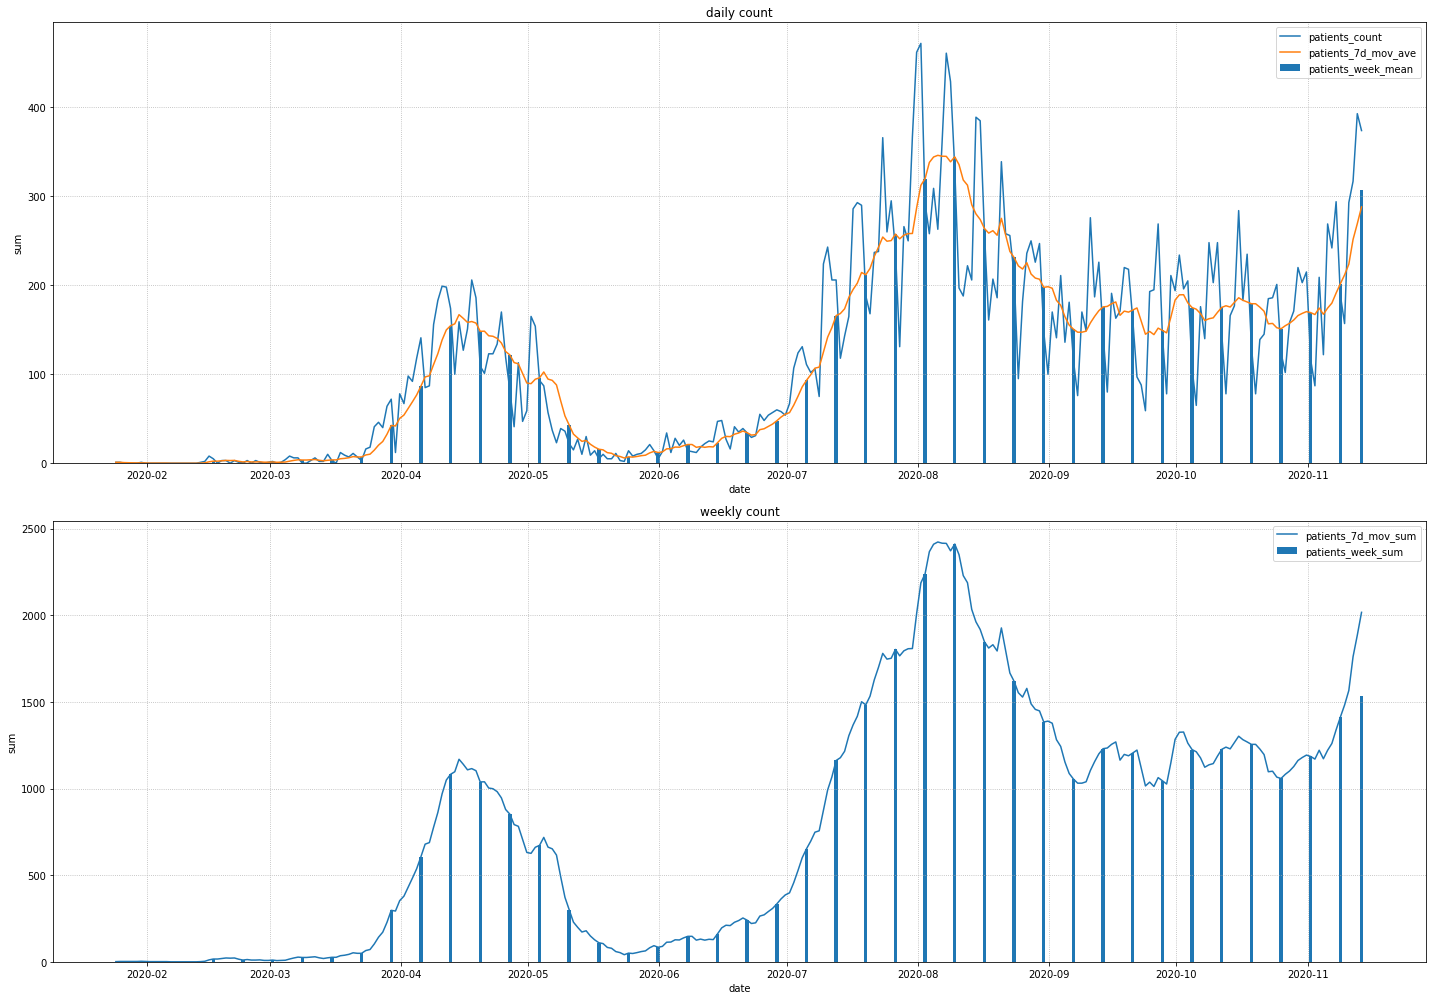

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(20, 14))

### 日毎の数
ax[0].set_title('daily count')
ax[0].set_xlabel('date')
ax[0].set_ylabel('sum')
ax[0].plot(x, y1_1, label='patients_count')
ax[0].plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
ax[0].bar(x, y1_4, label='patients_week_mean')
ax[0].grid(linestyle=':')
ax[0].legend()

### 週毎の合計
ax[1].set_title('weekly count')
ax[1].set_xlabel('date')
ax[1].set_ylabel('sum')
ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
ax[1].bar(x, y2_2, label='patients_week_sum')
ax[1].grid(linestyle=':')
ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
280,1.604045e+09,2020,10,30,1,0,0,0,0,0,0,280,0,206,365,366.000000,2562.0,0,870.714286,6095.0,203,168.428571,1179.0
281,1.604131e+09,2020,10,31,0,0,1,0,0,0,0,281,0,207,367,369.714286,2588.0,0,768.428571,5379.0,215,170.428571,1193.0
282,1.604218e+09,2020,11,1,0,0,0,1,0,0,0,282,0,208,379,375.857143,2631.0,0,665.857143,4661.0,116,169.285714,1185.0
283,1.604304e+09,2020,11,2,0,1,0,0,0,0,0,283,0,209,383,367.000000,2569.0,0,459.714286,3218.0,87,167.142857,1170.0
284,1.604390e+09,2020,11,3,0,0,0,0,0,1,0,284,0,210,510,382.142857,2675.0,0,306.285714,2144.0,209,174.428571,1221.0
285,1.604477e+09,2020,11,4,0,0,0,0,0,0,1,285,0,211,387,388.285714,2718.0,0,166.000000,1162.0,122,167.428571,1172.0
286,1.604563e+09,2020,11,5,0,0,0,0,1,0,0,286,0,212,331,388.857143,2722.0,0,0.000000,0.0,269,174.428571,1221.0
287,1.604650e+09,2020,11,6,1,0,0,0,0,0,0,287,0,213,363,388.571429,2720.0,0,0.000000,0.0,242,180.000000,1260.0
288,1.604736e+09,2020,11,7,0,0,1,0,0,0,0,288,0,214,480,404.714286,2833.0,0,0.000000,0.0,294,191.285714,1339.0
289,1.604822e+09,2020,11,8,0,0,0,1,0,0,0,289,0,215,382,405.142857,2836.0,0,0.000000,0.0,189,201.714286,1412.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295 entries, 0 to 294
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            295 non-null    float64
 1   year                 295 non-null    int64  
 2   month                295 non-null    int64  
 3   day                  295 non-null    int64  
 4   Fri                  295 non-null    uint8  
 5   Mon                  295 non-null    uint8  
 6   Sat                  295 non-null    uint8  
 7   Sun                  295 non-null    uint8  
 8   Thu                  295 non-null    uint8  
 9   Tue                  295 non-null    uint8  
 10  Wed                  295 non-null    uint8  
 11  passed               295 non-null    int64  
 12  emergency            295 non-null    int64  
 13  em_passed            295 non-null    int64  
 14  contacts_count       295 non-null    int64  
 15  contacts_7d_mov_ave  295 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,2.950000e+02,295.0,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.00000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000
mean,1.592554e+09,2020.0,6.108475,15.664407,0.145763,0.142373,0.142373,0.142373,0.142373,0.142373,0.142373,147.00000,0.166102,82.406780,770.481356,767.844956,5374.901695,1246.532203,1246.532203,8725.725424,115.742373,112.428717,786.945763
std,7.370212e+06,0.0,2.819109,8.945370,0.353468,0.350026,0.350026,0.350026,0.350026,0.350026,0.350026,85.30338,0.372804,73.082313,491.055325,477.895383,3345.288530,805.114120,629.023505,4403.164533,108.924464,97.443758,682.169960
min,1.579853e+09,2020.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.586203e+09,2020.0,4.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,73.50000,0.000000,0.000000,445.000000,453.928571,3177.500000,663.000000,928.285714,6498.000000,12.000000,13.000000,91.000000
50%,1.592554e+09,2020.0,6.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,147.00000,0.000000,73.000000,613.000000,633.571429,4435.000000,1272.000000,1239.285714,8675.000000,97.000000,111.714286,782.000000
75%,1.598904e+09,2020.0,8.500000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,220.50000,0.000000,146.500000,963.000000,953.142857,6672.000000,1777.000000,1700.142857,11901.000000,192.000000,175.642857,1229.500000
max,1.605254e+09,2020.0,11.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,294.00000,1.000000,220.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,472.000000,346.142857,2423.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000,NaN,0.994583,-0.022220,0.000000e+00,-0.002392,-0.011961,-0.007177,0.011961,0.002392,0.007177,1.000000e+00,-0.256802,0.981501,-0.042912,0.003095,0.003101,0.217359,0.348138,0.348138,0.668286,0.728728,0.728799
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,0.994583,NaN,1.000000,-0.125877,-2.267906e-03,-0.001916,-0.012257,-0.005363,0.011872,0.001531,0.008425,9.945830e-01,-0.253458,0.975319,-0.039078,0.005305,0.005312,0.215054,0.347039,0.347039,0.669076,0.728229,0.728308
day,-0.022220,NaN,-0.125877,1.000000,2.197777e-02,-0.004242,0.003362,-0.016192,0.000103,0.007707,-0.012933,-2.222047e-02,0.001473,-0.020331,-0.009971,0.003655,0.003649,0.023999,0.007187,0.007187,-0.055370,-0.048138,-0.048220
Fri,0.000000,NaN,-0.002268,0.021978,1.000000e+00,-0.168306,-0.168306,-0.168306,-0.168306,-0.168306,-0.168306,3.206172e-18,-0.003675,0.003227,-0.030016,-0.011015,-0.011014,0.044332,-0.016345,-0.016345,0.103104,0.004359,0.004307
Mon,-0.002392,NaN,-0.001916,-0.004242,-1.683055e-01,1.000000,-0.166008,-0.166008,-0.166008,-0.166008,-0.166008,-2.392244e-03,0.000619,-0.002671,0.052199,0.001402,0.001403,0.263911,0.002751,0.002751,-0.177906,-0.004068,-0.004056
Sat,-0.011961,NaN,-0.012257,0.003362,-1.683055e-01,-0.166008,1.000000,-0.166008,-0.166008,-0.166008,-0.166008,-1.196122e-02,0.000619,-0.010914,0.038861,-0.000788,-0.000787,-0.297063,0.002751,0.002751,0.109448,-0.008947,-0.008985
Sun,-0.007177,NaN,-0.005363,-0.016192,-1.683055e-01,-0.166008,-0.166008,1.000000,-0.166008,-0.166008,-0.166008,-7.176732e-03,0.000619,-0.006793,-0.009107,0.000321,0.000323,-0.273418,0.002751,0.002751,-0.054168,-0.006288,-0.006292
Thu,0.011961,NaN,0.011872,0.000103,-1.683055e-01,-0.166008,-0.166008,-0.166008,1.000000,-0.166008,-0.166008,1.196122e-02,0.000619,0.009961,-0.008415,0.004490,0.004491,0.079487,0.002751,0.002751,0.110340,0.010200,0.010232
Tue,0.002392,NaN,0.001531,0.007707,-1.683055e-01,-0.166008,-0.166008,-0.166008,-0.166008,1.000000,-0.166008,2.392244e-03,0.000619,0.001451,-0.026225,0.002302,0.002304,0.107404,0.002751,0.002751,-0.035523,0.000096,0.000118


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,1.604909e+09,0,1,0,0,0,0,0,290,0,216,372,0,157,211.714286,1482.0
291,1.604995e+09,0,0,0,0,0,1,0,291,0,217,310,0,293,223.714286,1566.0
292,1.605082e+09,0,0,0,0,0,0,1,292,0,218,373,0,317,251.571429,1761.0
293,1.605168e+09,0,0,0,0,1,0,0,293,0,219,380,0,393,269.285714,1885.0


In [26]:
import seaborn as sns

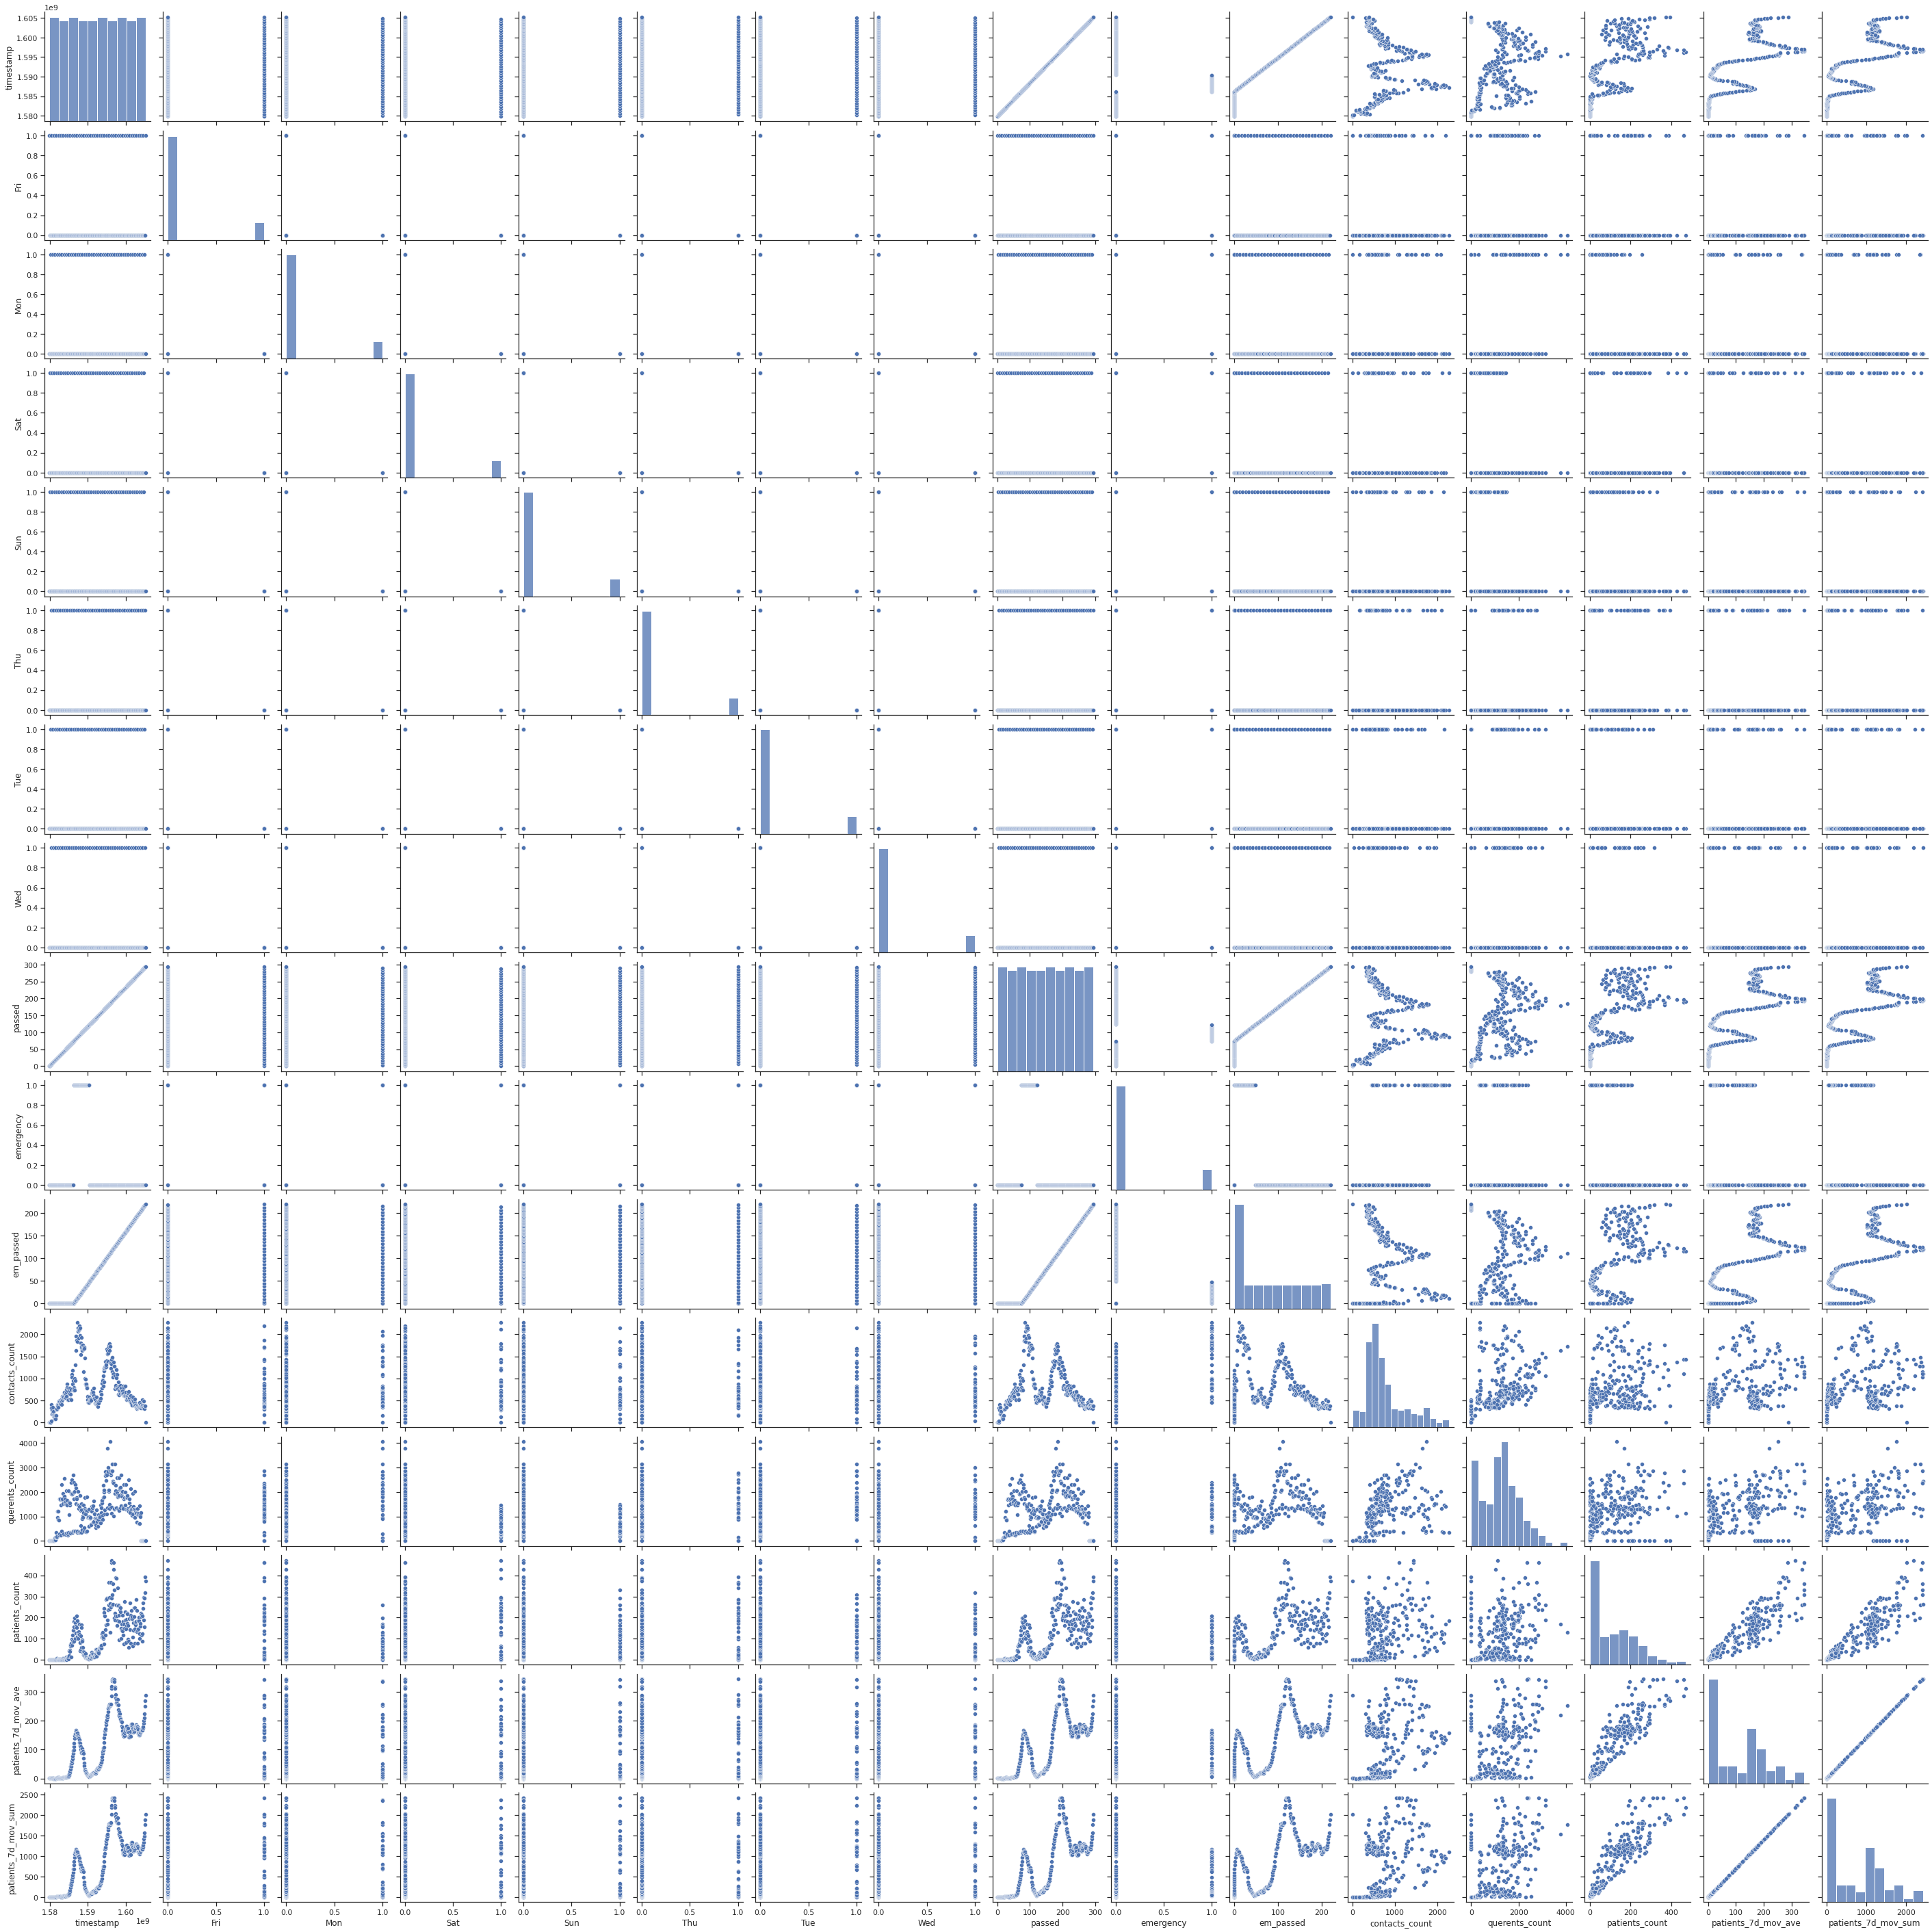

In [27]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(data=_df);

In [28]:
!python -V

Python 3.6.9
